In [1]:
# %matplotlib notebook

In [2]:
#dependencies
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import pprint as pprint
pd.set_option('display.max_columns', 50) #expand all dfs otherwise df with many columsn will be truncated

In [3]:
#import csv data files
# File to Load 
ad_data_to_load = "csv_data/Ad3.csv" #ad data file (only working with 1 of the 3)
cost_of_goods_to_load = "csv_data/cost_of_goods.csv" #cost of goods file
transactions_to_load="csv_data/transactions_main.csv" #transactions file

# Read the csvs
ad_data_raw =pd.read_csv(ad_data_to_load, index_col=False)
cost_of_goods_raw =pd.read_csv(cost_of_goods_to_load)
transactions_raw =pd.read_csv(transactions_to_load)

#create dfs
ad_df_raw = pd.DataFrame(ad_data_raw)
cog_df_raw = pd.DataFrame(cost_of_goods_raw)
trans_df_raw = pd.DataFrame(transactions_raw)

#merge trans df and cost of goods df together on 'sku'
combo_df =pd.merge(trans_df_raw, cog_df_raw, how='outer', on='sku', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None) #should probably get rid of suffixes


In [4]:
combo_df.loc[:, 'date/time'].replace(regex=True,inplace=True,to_replace="PST", value="") #remove 'PST' from date/time; if PST or PDT remain an error will occur when converting 
combo_df.loc[:, 'date/time'].replace(regex=True,inplace=True,to_replace="PDT", value="") #remove 'PDT' from date/time; if PST or PDT remain an error will occur when converting
combo_df['date/time']=pd.to_datetime(combo_df['date/time']) #converts string date/time to datetime
combo_df.infer_objects(); #changes column types. Most are strings or objects and this converts them to floats. This may not be needed. Need to double check. But it works so keep it for now.


In [5]:
def trans_cols(x): #creates new cols and their calculations
    x['transaction revenue']= x['total']-x['est_cost_unit']#revenue generate from transaction (revenue - cost of goods)
    x['sale price']= x['product sales']/x['quantity']#generates price of item at sale
    #x['Day of Week']=""  #Mon, Tues, Weds etc...
    x['Cost of Goods']=x['quantity']*x['est_cost_unit'] #total cost of goods for transaction; used to tally reorder amounts
    x['Whole Date'] =pd.to_datetime(combo_df['date/time']).apply(lambda y: y.date()) #converts timestamp to date
    
trans_cols(combo_df) #apply the trans_cols function to create new columns
short_trans_df=combo_df.drop(['settlement id','order id','marketplace','fulfillment'],axis=1) #drop unimportant columns and create a smaller df
short_trans_df.sort_values('date/time').reset_index().head(5) #sort df and reset index to match
short_trans_df['sale price'] = short_trans_df['sale price'].round(2)
short_trans_df.head()

,date/time,type,sku,description,quantity,order city,order state,order postal,product sales,shipping credits,gift wrap credits,promotional rebates,sales tax collected,Marketplace Facilitator Tax,selling fees,fba fees,other transaction fees,other,total,asin,group,parent,child,est_cost_unit,pick_n_pack_fee,transaction revenue,sale price,Cost of Goods,Whole Date
0,2017-02-07 08:23:12,Order,1I-A550-7LTL,Bamboo Salt Box by Iconic Home,1.0,Lawrence,KS,66049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.50,0.0,0.0,-5.50,B01N5TVYVD,Bamboo Salt Boxes,Bamboo Salt Box,Bamboo Salt Box,0.66,4.18,-6.16,0.0,0.66,2017-02-07
1,2017-02-07 08:23:12,Order,1I-A550-7LTL,Bamboo Salt Box by Iconic Home,1.0,Lawrence,KS,66049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.75,0.0,0.0,-0.75,B01N5TVYVD,Bamboo Salt Boxes,Bamboo Salt Box,Bamboo Salt Box,0.66,4.18,-1.41,0.0,0.66,2017-02-07
2,2017-04-11 18:48:27,Order,1I-A550-7LTL,Bamboo Salt Box by Iconic Home,1.0,St. Louis,MO,63139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.50,0.0,0.0,-8.50,B01N5TVYVD,Bamboo Salt Boxes,Bamboo Salt Box,Bamboo Salt Box,0.66,4.18,-9.16,0.0,0.66,2017-04-11
3,2017-04-11 18:48:27,Order,1I-A550-7LTL,Bamboo Salt Box by Iconic Home,1.0,St. Louis,MO,63139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.75,0.0,0.0,-0.75,B01N5TVYVD,Bamboo Salt Boxes,Bamboo Salt Box,Bamboo Salt Box,0.66,4.18,-1.41,0.0,0.66,2017-04-11
4,2017-05-11 00:35:02,Order,1I-A550-7LTL,Bamboo Salt Box by Iconic Home,1.0,Wildwood,MO,63040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.50,0.0,0.0,-8.50,B01N5TVYVD,Bamboo Salt Boxes,Bamboo Salt Box,Bamboo Salt Box,0.66,4.18,-9.16,0.0,0.66,2017-05-11


In [6]:
ad_data_clean=ad_data_raw
ad_data_clean['Date'] =pd.to_datetime(ad_data_clean['Date']).apply(lambda y: y.date())#converts string date to date

def ad_cols(x): #creates new cols and their calculations
    x['Whole Date'] =pd.to_datetime(ad_data_clean['Date']).apply(lambda y: y.date()) #converts timestamp to date
    
ad_cols(ad_data_clean) #apply the trans_cols function to create new columns
short_ad_df=ad_data_clean.drop(['Currency'],axis=1) #drop unimportant columns and create a smaller df
short_ad_df['Spend']=short_ad_df['Spend'].replace('[\$,]', '', regex=True).astype(float) #removes $ and converts to float
short_ad_df.head(5)

,Date,Campaign Name,Ad Group Name,Advertised SKU,Advertised ASIN,Impressions,Clicks,Click-Thru Rate (CTR),Cost Per Click (CPC),Spend,7 Day Total Sales,Total Advertising Cost of Sales (ACoS),Total Return on Advertising Spend (RoAS),7 Day Total Orders (#),7 Day Total Units (#),7 Day Conversion Rate,7 Day Advertised SKU Units (#),7 Day Other SKU Units (#),7 Day Advertised SKU Sales,7 Day Other SKU Sales,Whole Date
0,2018-05-08,Copper Ant Guard-Qty-3-Auto,Ad Group 1,Ant Guard Qty 3,B0763T3CTK,0,0,NaN,NaN,0.00,$0.00,NaN,NaN,0,0,NaN,0,0,$0.00,$0.00,2018-05-08
1,2018-05-07,Survival Bracelet-Toggle-Manual-1,Ad Group 1,ZW-OAUA-9YZW,B00WW1H6PC,19,0,0.00%,NaN,0.00,$0.00,NaN,NaN,0,0,NaN,0,0,$0.00,$0.00,2018-05-07
2,2018-05-08,Survival Bracelet-Toggle-Manual-1,Ad Group 1,ZW-OAUA-9YZW,B00WW1H6PC,16,0,0.00%,NaN,0.00,$0.00,NaN,NaN,0,0,NaN,0,0,$0.00,$0.00,2018-05-08
3,2018-05-09,Survival Bracelet-Toggle-Manual-1,Ad Group 1,ZW-OAUA-9YZW,B00WW1H6PC,12,0,0.00%,NaN,0.00,$0.00,NaN,NaN,0,0,NaN,0,0,$0.00,$0.00,2018-05-09
4,2018-05-10,Survival Bracelet-Toggle-Manual-1,Ad Group 1,ZW-OAUA-9YZW,B00WW1H6PC,11,1,9.09%,$0.08,0.08,$0.00,NaN,0.0,0,0,0.00%,0,0,$0.00,$0.00,2018-05-10


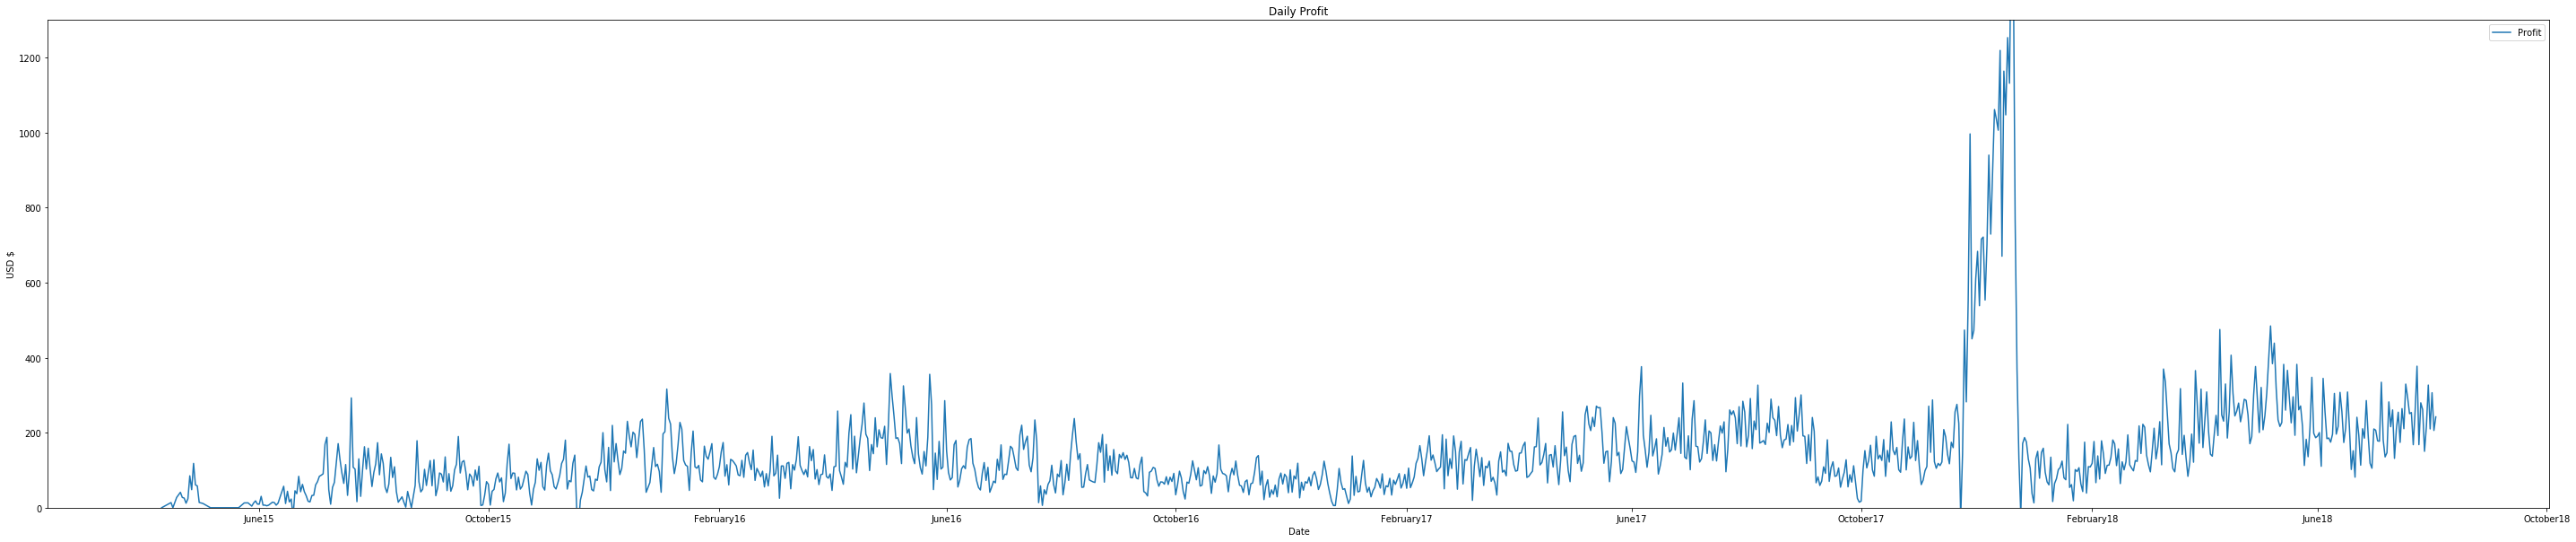

In [7]:
#profit graph
def profit_graph():
    
    def trans_rev(x): #create a df with sum transactions grouped by date
        cols={'Transaction Revenue':x['transaction revenue'].sum()}
        return pd.Series(cols)
    rev_df=combo_df.groupby('Whole Date').apply(trans_rev)
    rev_df.reset_index;()#reset index so "Whole Date" can be used
     
    def ad_spend_daily(x): #create a df with sum transactions grouped by date
        cols={'Ad Spend':x['Spend'].sum()}
        return pd.Series(cols)
    daily_ad_spend_df=short_ad_df.groupby(['Date']).apply(ad_spend_daily)
    
    prof_df =pd.merge(daily_ad_spend_df, rev_df, how='outer', left_on="Date", right_on="Whole Date",
             left_index=False, right_index=True, sort=True,
             suffixes=('_x', '_y'), copy=True, indicator=False,
             validate=None)
    #prof_df.head()
    prof_df['Profit']=prof_df['Transaction Revenue']-prof_df['Ad Spend']
    prof_df['Profit'].fillna(prof_df['Transaction Revenue'],inplace=True)
    x=prof_df.index
    y=prof_df['Profit'] 
    
    fig = plt.figure(figsize=(50,10))#creates figure
    ax= fig.add_subplot(1,1,1)
    ax.set_ylim([0,1300])
    ax.plot(x, y)
    ax.set_title('Daily Profit')
    ax.set_xlabel('Date')
    ax.set_ylabel('USD $')
    ax.legend(loc='best')

    
    myFmt = mdates.DateFormatter('%B%y')
    ax.xaxis.set_major_formatter(myFmt)
    fig.savefig('Images/profitTimeline.png')
profit_graph()



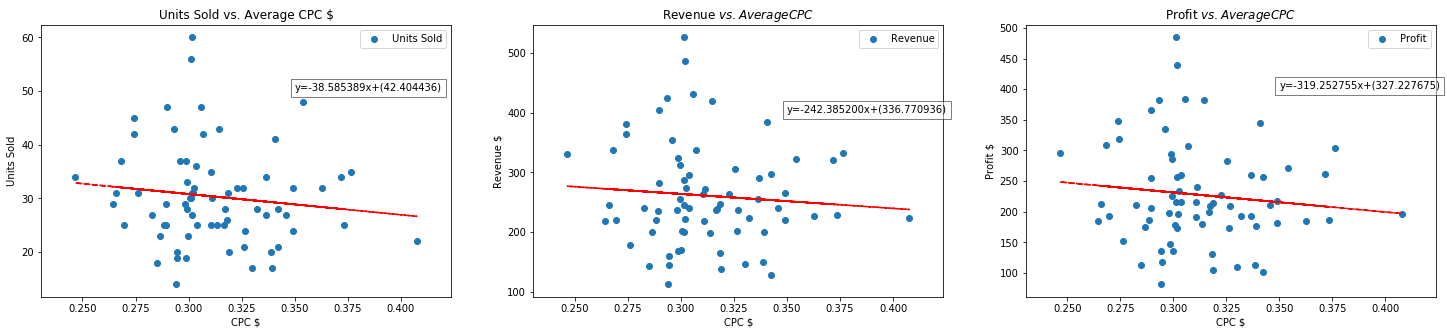

In [8]:
def cpc_graphs(): #graphs for cpc data for all groups
    
    def cpc(x): #create a df with average cost per click
        cols={'Average CPC':x['Spend'].sum()/x['Clicks'].sum(),
              'Total Spend': x['Spend'].sum()}
        return pd.Series(cols)
    daily_cpc_average_df=short_ad_df.groupby('Date').apply(cpc)
    daily_cpc_average_df.reset_index( inplace = True)

    def trans(x): #create a df with transaction data grouped by date
        cols={'Units Sold':x['quantity'].sum(),
              'Revenue': x['transaction revenue'].sum()}
        return pd.Series(cols)

    trans_df=short_trans_df.groupby('Whole Date').apply(trans)
    trans_df.reset_index(inplace = True)#reset index so "Whole Date" can be used

    cpc_v_trans_df =pd.merge(daily_cpc_average_df, trans_df, how='inner', left_on="Date", right_on="Whole Date")
    cpc_v_trans_df['Profit']= cpc_v_trans_df['Revenue'] - cpc_v_trans_df['Total Spend']

    x=cpc_v_trans_df['Average CPC']
    y=cpc_v_trans_df['Units Sold']

    fig = plt.figure(figsize=(25,5))#creates figure 

    ax= fig.add_subplot(1,3,1)
    ax.scatter(x, y)

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x,p(x),"r--")
    # the line equation:
    equation="y=%.6fx+(%.6f)"%(z[0],z[1])

    ax.set_title('Units Sold vs. Average CPC $')
    ax.set_xlabel('CPC $')
    ax.set_ylabel('Units Sold')
    ax.legend(loc='best')
    ax.text(.35,50,equation,bbox=dict(facecolor='white',alpha=0.5))

    x2=cpc_v_trans_df['Average CPC']
    y2=cpc_v_trans_df['Revenue']

    ax2= fig.add_subplot(1,3,2)
    ax2.scatter(x2, y2)

    z2 = np.polyfit(x2, y2, 1)
    p2 = np.poly1d(z2)
    ax2.plot(x2,p2(x2),"r--")
    # the line equation:
    equation2="y=%.6fx+(%.6f)"%(z2[0],z2[1])

    ax2.set_title('Revenue $ vs. Average CPC $')
    ax2.set_xlabel('CPC $')
    ax2.set_ylabel('Revenue $')
    ax2.legend(loc='best')
    ax2.text(.35,400,equation2,bbox=dict(facecolor='white',alpha=0.5))

    x3=cpc_v_trans_df['Average CPC']
    y3=cpc_v_trans_df['Profit'] 

    ax3= fig.add_subplot(1,3,3)
    ax3.scatter(x3, y3)

    z3 = np.polyfit(x3, y3, 1)
    p3 = np.poly1d(z3)
    ax3.plot(x3,p3(x3),"r--")
    # the line equation:
    equation3="y=%.6fx+(%.6f)"%(z3[0],z3[1])

    ax3.set_title('Profit $ vs. Average CPC $')
    ax3.set_xlabel('CPC $')
    ax3.set_ylabel('Profit $')
    ax3.legend(loc='best')
    ax3.text(.35,400,equation3,bbox=dict(facecolor='white',alpha=0.5))
    fig.savefig('Images/CPCspend.png')
cpc_graphs()

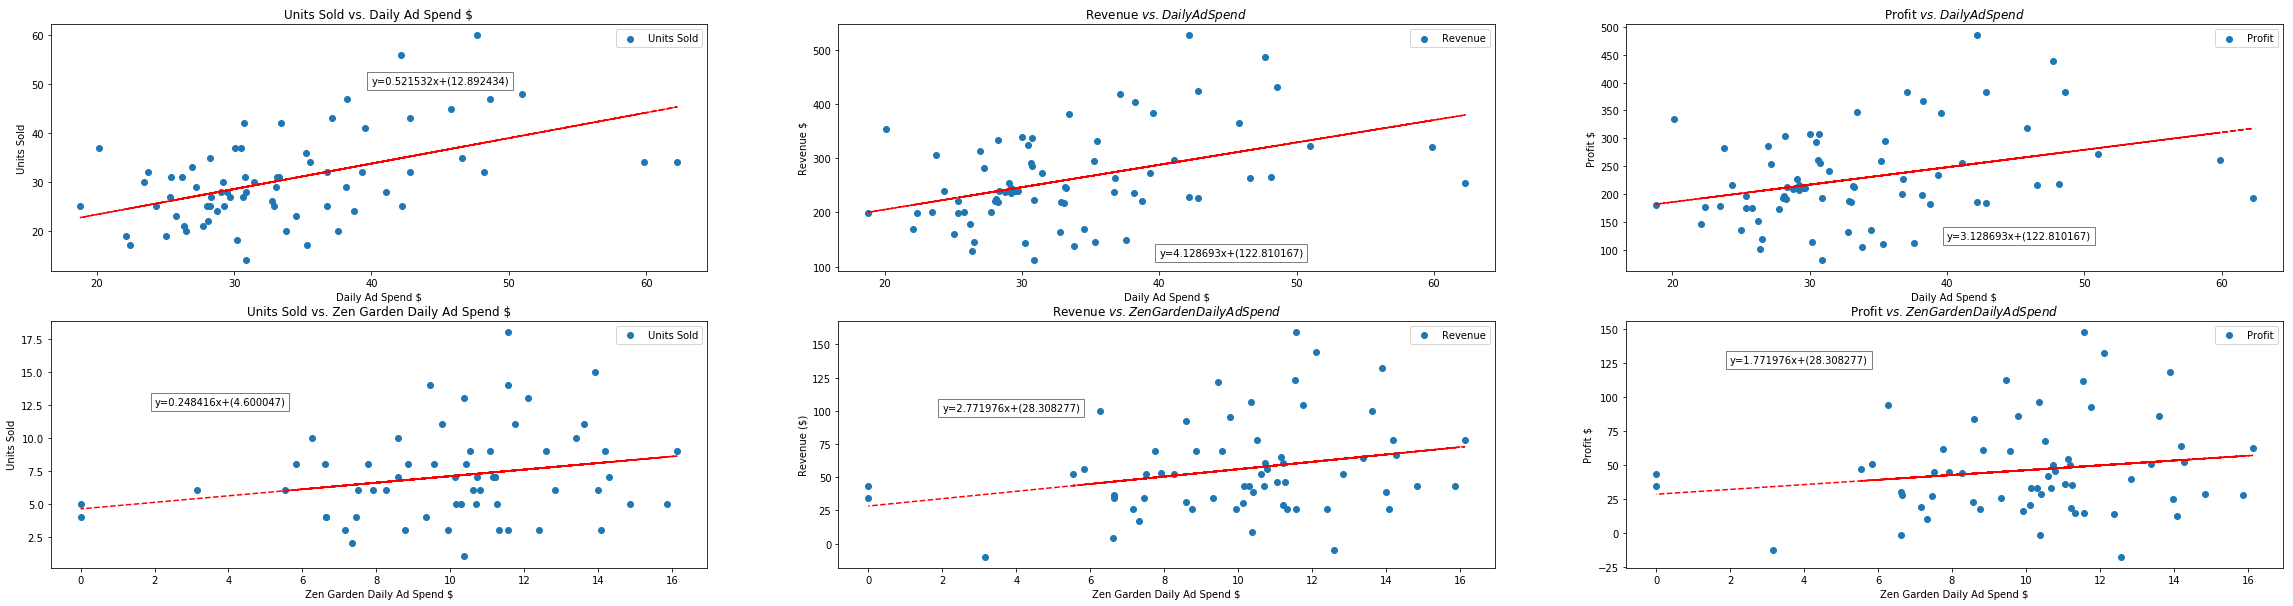

In [9]:
def daily_ad_spend_graphs(): #graphs to determine if advertising increases profit
    sku_of_interest ='UK-AVWR-4MNQ'
    
    def ad_spend(x): #create a df with sum ad spend grouped by date
        cols={'Daily Ad Spend':x['Spend'].sum()}
        return pd.Series(cols)
    daily_ad_df=short_ad_df.groupby('Date').apply(ad_spend)
    daily_ad_df.reset_index(inplace=True)

    def sales(x): #create a df with uits sold grouped by date
        cols={'Units Sold':x['quantity'].sum(),
              'Revenue': x['transaction revenue'].sum(),}
        return pd.Series(cols)

    sales_df=short_trans_df.groupby('Whole Date').apply(sales)
    sales_df.reset_index()#reset index so "Whole Date" can be used

    daily_ad_df2 =pd.merge(daily_ad_df, sales_df, how='inner', left_on="Date", right_on="Whole Date") #merge dfs
    daily_ad_df2['Profit']= daily_ad_df2['Revenue']- daily_ad_df2['Daily Ad Spend'] # ad a profit column

    fig = plt.figure(figsize=(40,10))#creates figure 
    
    x=daily_ad_df2['Daily Ad Spend'] 
    y=daily_ad_df2['Units Sold']

    ax= fig.add_subplot(2,3,1)
    ax.scatter(x, y)

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x,p(x),"r--")
    # the line equation:
    equation="y=%.6fx+(%.6f)"%(z[0],z[1])

    ax.set_title('Units Sold vs. Daily Ad Spend $')
    ax.set_xlabel('Daily Ad Spend $')
    ax.set_ylabel('Units Sold')
    ax.legend(loc='best')
    ax.text(40,50,equation,bbox=dict(facecolor='white',alpha=0.5))


    x2=daily_ad_df2['Daily Ad Spend']
    y2=daily_ad_df2['Revenue']

    ax2= fig.add_subplot(2,3,2)
    ax2.scatter(x2, y2)

    z2= np.polyfit(x2, y2, 1)
    p2 = np.poly1d(z2)
    ax2.plot(x2,p2(x2),"r--")
    # the line equation:
    equation2="y=%.6fx+(%.6f)"%(z2[0],z2[1])

    ax2.set_title('Revenue $ vs. Daily Ad Spend $')
    ax2.set_xlabel('Daily Ad Spend $')
    ax2.set_ylabel('Revenue $')
    ax2.legend(loc='best')
    ax2.text(40,120,equation2,bbox=dict(facecolor='white',alpha=0.5))

    
    x3=daily_ad_df2['Daily Ad Spend']
    y3=daily_ad_df2['Profit']

    ax3= fig.add_subplot(2,3,3)
    ax3.scatter(x3, y3)

    z3= np.polyfit(x3, y3, 1)
    p3 = np.poly1d(z3)
    ax3.plot(x3,p3(x3),"r--")
    # the line equation:
    equation3="y=%.6fx+(%.6f)"%(z3[0],z3[1])

    ax3.set_title('Profit $ vs. Daily Ad Spend $')
    ax3.set_xlabel('Daily Ad Spend $')
    ax3.set_ylabel('Profit $')
    ax3.legend(loc='best')
    ax3.text(40,120,equation3,bbox=dict(facecolor='white',alpha=0.5))
    
    #create similar graphs as above but with a single SKU
    def zen_sales(x): 
        cols={'Units Sold':x['quantity'].sum(),
              'Revenue': x['transaction revenue'].sum(),}
        return pd.Series(cols)
    zen_df=short_trans_df[short_trans_df['sku']==sku_of_interest]
    zen_df2=zen_df.groupby('Whole Date').apply(zen_sales)
    zen_df2.reset_index()#reset index so "Whole Date" can be used
    
    def zen_ad_spend(x): 
        cols={'Daily Ad Spend':x['Spend'].sum()}
        return pd.Series(cols)
    zen_ad_df= short_ad_df[short_ad_df['Advertised SKU']==sku_of_interest]
    zen_ad_df2=zen_ad_df.groupby('Date').apply(zen_ad_spend)
    zen_ad_df2.reset_index(inplace=True)

    zen_ad_df3 =pd.merge(zen_ad_df, zen_df2, how='inner', left_on="Date", right_on="Whole Date")
    zen_ad_df3['Profit']=zen_ad_df3['Revenue']-zen_ad_df3['Spend']
    x4=zen_ad_df3['Spend']
    y4=zen_ad_df3['Units Sold']
    
    ax4= fig.add_subplot(2,3,4)
    ax4.scatter(x4, y4)

    z4 = np.polyfit(x4, y4, 1)
    p4 = np.poly1d(z4)
    ax4.plot(x4,p4(x4),"r--")
    # the line equation:
    equation4="y=%.6fx+(%.6f)"%(z4[0],z4[1])

    ax4.set_title('Units Sold vs. Zen Garden Daily Ad Spend $')
    ax4.set_xlabel('Zen Garden Daily Ad Spend $')
    ax4.set_ylabel('Units Sold')
    ax4.legend(loc='best')
    ax4.text(2,12.5,equation4,bbox=dict(facecolor='white',alpha=0.5))
    
    x5=zen_ad_df3['Spend']
    y5=zen_ad_df3['Revenue']
    
    ax5= fig.add_subplot(2,3,5)
    ax5.scatter(x5, y5)

    z5 = np.polyfit(x5, y5, 1)
    p5 = np.poly1d(z5)
    ax5.plot(x5,p5(x5),"r--")
    # the line equation:
    equation5="y=%.6fx+(%.6f)"%(z5[0],z5[1])

    ax5.set_title('Revenue $ vs. Zen Garden Daily Ad Spend $')
    ax5.set_xlabel('Zen Garden Daily Ad Spend $')
    ax5.set_ylabel('Revenue ($)')
    ax5.legend(loc='best')
    ax5.text(2,100,equation5,bbox=dict(facecolor='white',alpha=0.5))
    
    x6=zen_ad_df3['Spend']
    y6=zen_ad_df3['Profit']
    
    ax6= fig.add_subplot(2,3,6)
    ax6.scatter(x6, y6)

    z6 = np.polyfit(x6, y6, 1)
    p6 = np.poly1d(z6)
    ax6.plot(x6,p6(x6),"r--")
    # the line equation:
    equation6="y=%.6fx+(%.6f)"%(z6[0],z6[1])

    ax6.set_title('Profit $ vs. Zen Garden Daily Ad Spend $')
    ax6.set_xlabel('Zen Garden Daily Ad Spend $')
    ax6.set_ylabel('Profit $')
    ax6.legend(loc='best')
    ax6.text(2,125,equation6,bbox=dict(facecolor='white',alpha=0.5))
    fig.savefig('Images/ad_spend.png')
daily_ad_spend_graphs() #trendline equations seem off

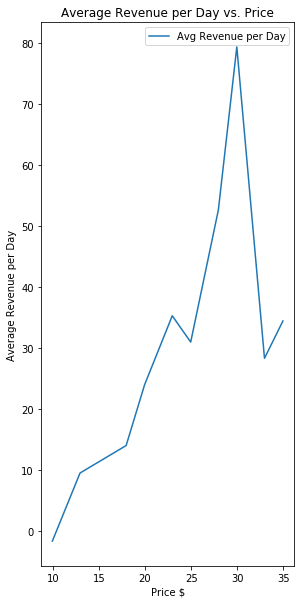

In [10]:
def price_v_sales():
    #sku_of_interest='UK-AVWR-4MNQ' #Zen Garden
    sku_of_interest='L3-RWTL-UEM7' #Zen Garden 003
    #sku_of_interest='AX-HJ6W-YXN8' #Ant Guard Qty 1

    sku_df=short_trans_df[short_trans_df['sku']==sku_of_interest]
    sku_df =sku_df[sku_df['type'] =='Order']
    sku_df= sku_df[sku_df['sale price'] !=0]

    def avg_price(x): #create a df with sum transactions grouped by date
        cols={#'Average Price':(x['sale price']*x['quantity']).sum()/x['quantity'].sum(),
              'Units Sold per Day': x['quantity'].sum(),
              'Revenue': x['transaction revenue'].sum()}
        return pd.Series(cols)
    avg_price_df=sku_df
    avg_price_df=sku_df.groupby(['sale price','Whole Date']).apply(avg_price)
    avg_price_df.dropna(inplace=True)#reset index so "Whole Date" can be used
    avg_price_df.reset_index(inplace=True)

    newDF=avg_price_df

    def avg_rev(x): #create a df with sum transactions grouped by date
        cols={#'Average Price':(x['sale price']*x['quantity']).sum()/x['quantity'].sum(),
              'Avg Units Sold per Day': x['Units Sold per Day'].mean(),
              'Avg Revenue per Day': x['Revenue'].mean(),
              'Days at Price': x['Whole Date'].count()}
        return pd.Series(cols)

    newDF2=newDF.groupby('sale price').apply(avg_rev)
    newDF2.reset_index(inplace=True)


    x=newDF2['sale price']
    y=newDF2['Avg Revenue per Day']

    fig = plt.figure(figsize=(10,10))#creates figure
    ax= fig.add_subplot(1,2,1)
    ax.plot(x, y)

    ax.set_title('Average Revenue per Day vs. Price')
    ax.set_xlabel('Price $')
    ax.set_ylabel('Average Revenue per Day')
    ax.legend(loc='best')
    fig.savefig('Images/priceVRevenue.png')
price_v_sales()

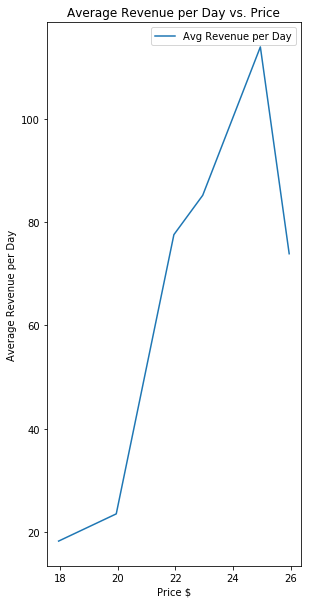

In [13]:
def price_v_sales2():
    #sku_of_interest='UK-AVWR-4MNQ' #Zen Garden
    #sku_of_interest='L3-RWTL-UEM7' #Zen Garden 003
    #sku_of_interest='AX-HJ6W-YXN8' #Ant Guard Qty 1
    sku_of_interest="Ant Guard Qty 3" #Ant Guard Qty3

    sku_df=short_trans_df[short_trans_df['sku']==sku_of_interest]
    sku_df =sku_df[sku_df['type'] =='Order']
    sku_df= sku_df[sku_df['sale price'] !=0]

    def avg_price(x): #create a df with sum transactions grouped by date
        cols={#'Average Price':(x['sale price']*x['quantity']).sum()/x['quantity'].sum(),
              'Units Sold per Day': x['quantity'].sum(),
              'Revenue': x['transaction revenue'].sum()}
        return pd.Series(cols)
    avg_price_df=sku_df
    avg_price_df=sku_df.groupby(['sale price','Whole Date']).apply(avg_price)
    avg_price_df.dropna(inplace=True)#reset index so "Whole Date" can be used
    avg_price_df.reset_index(inplace=True)

    newDF=avg_price_df

    def avg_rev(x): #create a df with sum transactions grouped by date
        cols={#'Average Price':(x['sale price']*x['quantity']).sum()/x['quantity'].sum(),
              'Avg Units Sold per Day': x['Units Sold per Day'].mean(),
              'Avg Revenue per Day': x['Revenue'].mean(),
              'Days at Price': x['Whole Date'].count()}
        return pd.Series(cols)

    newDF2=newDF.groupby('sale price').apply(avg_rev)
    newDF2.reset_index(inplace=True)


    x=newDF2['sale price']
    y=newDF2['Avg Revenue per Day']

    fig = plt.figure(figsize=(10,10))#creates figure
    ax= fig.add_subplot(1,2,1)
    ax.plot(x, y)

    ax.set_title('Average Revenue per Day vs. Price')
    ax.set_xlabel('Price $')
    ax.set_ylabel('Average Revenue per Day')
    ax.legend(loc='best')
    fig.savefig('Images/priceVRevenue.png')
price_v_sales2()

In [ ]:
#test change for amazon